In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import json

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Activation, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Init Plugin
Init Graph Optimizer
Init Kernel
Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Constants

In [2]:
d_name = '20210812_wmt19_cs_en'
folder_name = '20210814_translate_rmMLE'

wv_dim = 32
en_que_pad = 30
de_que_pad = 32

# Load data

In [3]:
encoder_train = pickle.load(open(f'{d_name}/encoder_train.pkl', 'rb'))
decoder_train = pickle.load(open(f'{d_name}/decoder_train.pkl', 'rb'))
teacher_train = pickle.load(open(f'{d_name}/teacher_train.pkl', 'rb'))
encoder_vali  = pickle.load(open(f'{d_name}/encoder_vali.pkl', 'rb'))
decoder_vali  = pickle.load(open(f'{d_name}/decoder_vali.pkl', 'rb'))
teacher_vali  = pickle.load(open(f'{d_name}/teacher_vali.pkl', 'rb'))

decoder_idx2word   = pickle.load(open(f'{d_name}/en_idx2word.pkl','rb'))
decoder_word2idx   = pickle.load(open(f'{d_name}/en_word2idx.pkl','rb'))
encoder_idx2word   = pickle.load(open(f'{d_name}/cs_idx2word.pkl','rb'))
encoder_word2idx   = pickle.load(open(f'{d_name}/cs_word2idx.pkl','rb'))

In [4]:
num_decoder_words = np.max([np.max(decoder_train), np.max(decoder_vali)])+1
num_encoder_words = np.max([np.max(encoder_train), np.max(encoder_vali)])+1

print(num_decoder_words)
print(num_encoder_words)

52575
52573


In [5]:
def seq2word(seq_tensor, idx2word):
    return np.array([' '.join([idx2word[str(i)] for i in seq]) for seq in seq_tensor])

seq2word(decoder_vali[:10], decoder_idx2word)

# Positional Encoding
[Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [6]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

## Test positional encoding

Metal device set to: Apple M1
(1, 10, 64)


2021-08-14 22:49:47.881643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-14 22:49:47.881713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


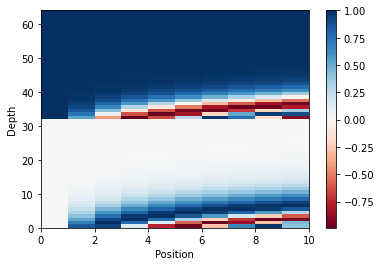

In [7]:
from matplotlib import pyplot as plt
n, d = 10, 64
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Generator

[OneHot relaxation](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/RelaxedOneHotCategorical)
based on [Jang+16](https://arxiv.org/abs/1611.01144) and [Maddison+16](https://arxiv.org/abs/1611.00712) 
<br>
[Multi-Head Attention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) 
and [Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [8]:
#TODO: It leaks the answer
def MHA(en_que_pad, de_que_pad, wv_dim, rate = 0.1, mask = True):
    # Inputs
    en_in = Input((en_que_pad, wv_dim))
    mem = Input((de_que_pad, wv_dim))
    # Constants
    ff_dim = wv_dim*16
    # Make q, k, v
    q = Dense(wv_dim)(mem)
    k = Dense(wv_dim)(en_in)
    peq = positional_encoding(de_que_pad, wv_dim)
    pek = positional_encoding(en_que_pad, wv_dim)
    # Position encoding
    q = tf.keras.layers.Add()([q, peq])
    k = tf.keras.layers.Add()([k, pek])
    v = k
    m = None
    mem_new = mem
    if mask:
        m = np.tri(de_que_pad, en_que_pad, 0)
        mem_new = MultiHeadAttention(
            num_heads = 4, 
            key_dim = wv_dim, 
            value_dim = wv_dim
        )(
            q, k,
            attention_mask = m,
        )
    else:
        m = np.ones((de_que_pad, en_que_pad))
        mem_new = MultiHeadAttention(
            num_heads = 4, 
            key_dim = wv_dim, 
            value_dim = wv_dim
        )(
            q, k, v,
            attention_mask = m,
        )
    #mem_new = Dropout(rate)(mem_new)
    mem_new = LayerNormalization(epsilon=1e-6)(mem_new+mem)
    # Feed-Forward skip-connection
    ffn = Dense(ff_dim, activation = 'relu')(mem_new)
    ffn = Dense(wv_dim)(ffn)
    #ffn = Dropout(rate)(ffn)
    out = LayerNormalization(epsilon=1e-6)(ffn+mem_new)
    model = Model(
        [en_in, mem],
        out
    )
    return model

def getG():
    # Encoder
    en_input = Input((en_que_pad,))
    en_emb = Embedding(
        num_encoder_words, 
        wv_dim, 
        mask_zero = False,
        input_length = en_que_pad,
        trainable = True,
    )
    vector_encoder = en_emb(en_input)
    en_output = vector_encoder
    
    # Deocder
    de_input = Input((de_que_pad,))
    de_emb = Embedding(
        num_decoder_words, 
        wv_dim, 
        mask_zero = False,
        input_length = de_que_pad,
        trainable = True,
    )
    vector_decoder = de_emb(de_input)   
    de_output = vector_decoder
    
    for i in range(1):
        # Encoding
        mhaLayer = MHA(en_que_pad, en_que_pad, wv_dim, mask = False)
        en_output = mhaLayer((vector_encoder, en_output))
        en_output = Activation('relu')(en_output)
    
        # Decoding
        mhaLayer = MHA(de_que_pad, de_que_pad, wv_dim)
        de_output = mhaLayer((vector_decoder, de_output))
        de_output = Activation('relu')(de_output)
        
        # Combine
        mhaLayer = MHA(en_que_pad, de_que_pad, wv_dim, mask = False)
        de_output = mhaLayer((en_output, de_output))
        de_output = Activation('relu')(de_output)
    
    # Concatenation and output
    de_output = Dense(num_decoder_words)(de_output)
    output = Activation('softmax')(de_output)
    model = Model(
        [en_input, de_input], 
        output,
    ) 
    return model


In [9]:
mleG=getG()
mleG.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)
mleG.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 32)       1682336     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 32)       1682400     input_2[0][0]                    
____________________________________________________________________________________________

In [10]:
mleG.fit(
    #[encoder_train, decoder_train], 
    #teacher_train, 
    [encoder_train[:10240], decoder_train[:10240]], 
    teacher_train[:10240],
    batch_size=64, 
    epochs=300, 
    shuffle=True, 
    validation_data = (
        #[encoder_vali, decoder_vali], 
        #teacher_vali,
        [encoder_vali[:640], decoder_vali[:640]], 
        teacher_vali[:640],
    ), 
    callbacks=[
        ModelCheckpoint(
            f'./{folder_name}/mleG.h5', 
            save_best_only=True, 
            monitor = "val_loss"
        ),
        EarlyStopping(monitor='val_loss', patience=5),
        CSVLogger(f'{folder_name}/mleG.csv'),
    ]
)

Epoch 1/300


2021-08-14 22:49:48.282415: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-14 22:49:48.282592: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-08-14 22:49:48.827493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 8.8411 - accuracy: 0.2749

2021-08-14 22:50:54.261340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 69s 425ms/step - loss: 8.8411 - accuracy: 0.2749 - val_loss: 6.8219 - val_accuracy: 0.4568
Epoch 2/300


/Users/jacob975/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


160/160 [==============================] - 69s 432ms/step - loss: 5.4527 - accuracy: 0.4384 - val_loss: 4.3996 - val_accuracy: 0.4568
Epoch 3/300
160/160 [==============================] - 67s 419ms/step - loss: 4.0336 - accuracy: 0.4688 - val_loss: 3.7477 - val_accuracy: 0.5143
Epoch 4/300
160/160 [==============================] - 65s 404ms/step - loss: 3.5609 - accuracy: 0.5197 - val_loss: 3.3096 - val_accuracy: 0.5651
Epoch 5/300
160/160 [==============================] - 69s 429ms/step - loss: 2.7653 - accuracy: 0.6084 - val_loss: 2.2277 - val_accuracy: 0.6925
Epoch 6/300
160/160 [==============================] - 74s 460ms/step - loss: 1.7471 - accuracy: 0.7443 - val_loss: 1.5053 - val_accuracy: 0.8059
Epoch 7/300
160/160 [==============================] - 68s 423ms/step - loss: 1.1415 - accuracy: 0.8341 - val_loss: 1.1423 - val_accuracy: 0.8628
Epoch 8/300
160/160 [==============================] - 66s 413ms/step - loss: 0.7958 - accuracy: 0.8855 - val_loss: 0.9385 - val_accurac

KeyboardInterrupt: 

# Inference

In [11]:
def inference(
    model,
    enData = None,
    inpData = None,
    start_on = 0,
    batch_size = 10,
):
    # Initialize
    num_data = len(enData)
    num_batch = (num_data-1)//batch_size +1
    print(num_batch)
    resp_pred_list = None
    in_batch_list = None
    the_first = True
    #idx = np.arange(num_words)
    for b in range(num_batch):
        in_batch = np.zeros((batch_size, de_que_pad), dtype = int)
        en_batch = np.zeros((batch_size, en_que_pad), dtype = int)
        if start_on == 0:
            in_batch[:,0] = decoder_word2idx['bos']
        else:
            in_batch = inpData[b*batch_size:(b+1)*batch_size]
            en_batch = enData[ b*batch_size:(b+1)*batch_size]
        resp_pred = np.zeros((batch_size, de_que_pad), dtype = int)
        # Generate the sequence recurrsively.
        for i in range(start_on, de_que_pad):
            #print(i)
            # Run
            resp_pred_wv = model([en_batch, in_batch])
            the_last = resp_pred_wv[:,i]
            #We the_last = tf.keras.backend.argmax(the_last).numpy()
            the_last = tf.reshape(
                tf.random.categorical(tf.math.log(the_last), 1), 
                [batch_size,]
            )
            try:
                resp_pred[:,i] = the_last
                in_batch[:,i+1] = the_last
            except:
                resp_pred[:,i] = the_last
        for i in range(len(resp_pred)):
            try:
                index = list(resp_pred[i]).index(decoder_word2idx['eos'])
            except:
                continue
            resp_pred[i,index+1:] = 0
            in_batch[i,index+1:] = 0
        if the_first:
            resp_pred_list = resp_pred
            in_batch_list = in_batch
            the_first = False
        else:
            resp_pred_list = np.vstack((resp_pred_list, resp_pred))
            in_batch_list = np.vstack((in_batch_list, in_batch))
    resp_pred_list = resp_pred_list[:num_data]
    in_batch_list = in_batch_list[:num_data]
    if start_on != 0:
        resp_pred_list[:,:start_on] = inpData[:,1:start_on+1]
        in_batch_list[:, :start_on+1] = inpData[:,:start_on+1]
    return resp_pred_list, in_batch_list

In [12]:
teacher_pred, decoder_pred = inference(
    mleG,
    encoder_vali[:16],
    batch_size = 16
)

1


In [13]:
print(seq2word(encoder_vali[2:3], encoder_idx2word))
print(seq2word(teacher_pred[2:3], decoder_idx2word))

['s\xa0usa za dne vyšší bez než nebo říct podle a nad rozvojové to – malárie nebo zůstává pad pad pad pad pad pad pad pad pad pad pad pad pad']
['eos pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad']
